# RQ: How do gRPC interceptors affect throughput and latency in microservice architectures?

In [14]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load & Clean Data

In [15]:
import datetime
import re
from datetime import timedelta
# base = purpl interceptor disabled altogether
# good = all attributes allowed
# bad = all attributes supressed
# mixed = allowed: 0, generalized: 0, noised: 3 (Gaussian), reduced: 2, supressed: 0
# rand = rand(good, bad, mixed)

# -------------- loading data -------------- #

result_purpl_good_1 = '../results/results_purpl_good_1.csv' # purpl_good
result_purpl_good_2 = '../results/results_purpl_good_2.csv' # purpl_good
result_purpl_good_3 = '../results/results_purpl_good_3.csv' # purpl_good

result_purpl_bad_1 = '../results/results_purpl_bad_1.csv'   # purpl_bad
result_purpl_bad_2 = '../results/results_purpl_bad_2.csv'   # purpl_bad
result_purpl_bad_3 = '../results/results_purpl_bad_3.csv'   # purpl_bad

result_purpl_base_1 = '../results/results_purpl_base_1.csv' # purpl_baseline
result_purpl_base_2 = '../results/results_purpl_base_2.csv' # purpl_baseline
result_purpl_base_3 = '../results/results_purpl_base_3.csv' # purpl_baseline

results_purpl_mixed_1 = '../results/results_purpl_mixed_1.csv' # purpl_mixed
results_purpl_mixed_2 = '../results/results_purpl_mixed_2.csv' # purpl_mixed
results_purpl_mixed_3 = '../results/results_purpl_mixed_3.csv' # purpl_mixed

results_purpl_rand_1 = '../results/results_purpl_rand_1.csv' # purpl_rand
results_purpl_rand_2 = '../results/results_purpl_rand_2.csv' # purpl_rand
results_purpl_rand_3 = '../results/results_purpl_rand_3.csv' # purpl_rand

# ---------------------------------------------------- #

data_purpl_good_1 = pd.read_csv(result_purpl_good_1)
data_purpl_good_2 = pd.read_csv(result_purpl_good_2)
data_purpl_good_3 = pd.read_csv(result_purpl_good_3)

data_purpl_bad_1 = pd.read_csv(result_purpl_bad_1)
data_purpl_bad_2 = pd.read_csv(result_purpl_bad_2)
data_purpl_bad_3 = pd.read_csv(result_purpl_bad_3)

data_purpl_base_1 = pd.read_csv(result_purpl_base_1)
data_purpl_base_2 = pd.read_csv(result_purpl_base_2)
data_purpl_base_3 = pd.read_csv(result_purpl_base_3)

data_purpl_mixed_1 = pd.read_csv(results_purpl_mixed_1)
data_purpl_mixed_2 = pd.read_csv(results_purpl_mixed_2)
data_purpl_mixed_3 = pd.read_csv(results_purpl_mixed_3)

data_purpl_rand_1 = pd.read_csv(results_purpl_rand_1)
data_purpl_rand_2 = pd.read_csv(results_purpl_rand_2)
data_purpl_rand_3 = pd.read_csv(results_purpl_rand_3)

datasets = [data_purpl_good_1, data_purpl_good_2, data_purpl_good_3,
            data_purpl_bad_1, data_purpl_bad_2, data_purpl_bad_3,
            data_purpl_base_1, data_purpl_base_2, data_purpl_base_3,
            data_purpl_mixed_1, data_purpl_mixed_2, data_purpl_mixed_3,
            data_purpl_rand_1, data_purpl_rand_2, data_purpl_rand_3]

# -------------- cleaning data -------------- #

# Helper function to convert latency string to float
def convert_latency_to_ms(latency_str):
    if 'ms' in latency_str:
        return float(latency_str.replace('ms', '').strip())
    elif 'µs' in latency_str:
        return float(latency_str.replace('µs', '').strip()) / 1000
    else:
        return 0
    
def remove_s(time_elapsed):
    # Extract the minutes from the time duration
    # format: 1m2.345s

    if 'm' in time_elapsed:
        minutes = time_elapsed.split('m')[0]
        seconds = time_elapsed.split('m')[1]
        seconds = float(seconds.replace('s', '').strip())

        result = float(minutes)*60 + seconds
        return result
    return float(time_elapsed.replace('s', '').strip())

# Apply the function to Min and Max Latency columns
for data in datasets:
    # remove the row of zeroes at the beginning (warmup/init)
    data.drop([0], inplace=True)

    data['Average Latency'] = data['Average Latency'].apply(convert_latency_to_ms)
    data['Max Latency'] = data['Max Latency'].apply(convert_latency_to_ms)
    data['Min Latency'] = data['Min Latency'].apply(convert_latency_to_ms)
    data['Time Elapsed'] = data['Time Elapsed'].apply(remove_s)

# -------------- helper functions -------------- #

def calculate_time_difference(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'].apply(lambda x: x.split('+')[0]))
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Calculate the time difference
    time_difference = df['Timestamp'].iloc[-1] - df['Timestamp'].iloc[0]
    
    return time_difference



## Turn 3 data files into 1 avg_data file

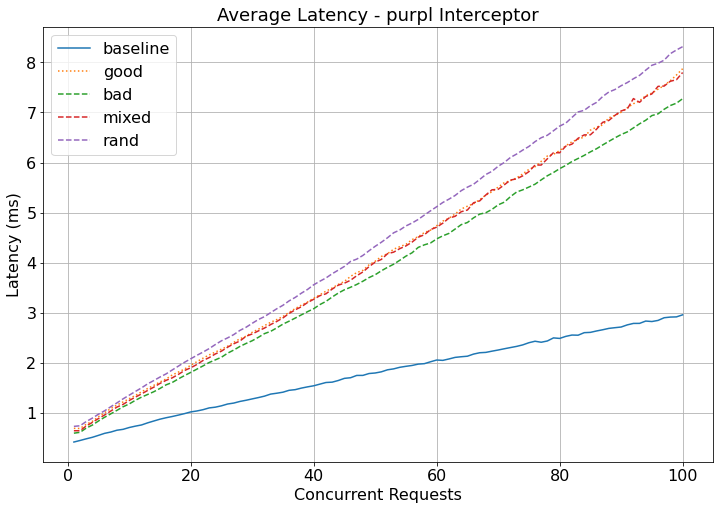

In [20]:
def calculate_average_df(df1, df2, df3):
    # Ensure that the DataFrames are aligned (same shape and index/column labels)
    if not (df1.shape == df2.shape == df3.shape and
            df1.index.equals(df2.index) and df1.index.equals(df3.index) and
            df1.columns.equals(df2.columns) and df1.columns.equals(df3.columns)):
        raise ValueError("All DataFrames must have the same shape and matching index and column labels.")
    
    # Identify numeric columns in the DataFrames
    numeric_cols = df1.select_dtypes(include=np.number).columns
    
    # Calculate the element-wise sum and then divide by 3 for numeric columns only
    average_df = pd.DataFrame(index=df1.index, columns=df1.columns)
    average_df[numeric_cols] = (df1[numeric_cols] + df2[numeric_cols] + df3[numeric_cols]) / 3

    return average_df

avg_purpl_good = calculate_average_df(data_purpl_good_1, data_purpl_good_2, data_purpl_good_3)
avg_purpl_bad = calculate_average_df(data_purpl_bad_1, data_purpl_bad_2, data_purpl_bad_3)
avg_purpl_base = calculate_average_df(data_purpl_base_1, data_purpl_base_2, data_purpl_base_3)

avg_purpl_mixed = calculate_average_df(data_purpl_mixed_1, data_purpl_mixed_2, data_purpl_mixed_3)


avg_purpl_rand = calculate_average_df(data_purpl_rand_1, data_purpl_rand_2, data_purpl_rand_3)


# -------------- plotting data -------------- #
plt.figure(figsize=(12, 8))
plt.plot(avg_purpl_base['Average Latency'], label='baseline')
plt.plot(avg_purpl_good['Average Latency'], label='good', linestyle='dotted')
plt.plot(avg_purpl_bad['Average Latency'], label='bad', linestyle='--')
plt.plot(avg_purpl_mixed['Average Latency'], label='mixed', linestyle='--')
plt.plot(avg_purpl_rand['Average Latency'], label='rand', linestyle='--')

plt.title('Average Latency - purpl Interceptor', fontsize=18)
plt.ylabel('Latency (ms)', fontsize=16)
plt.xlabel('Concurrent Requests', fontsize=16)
plt.grid(True)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)
plt.show()

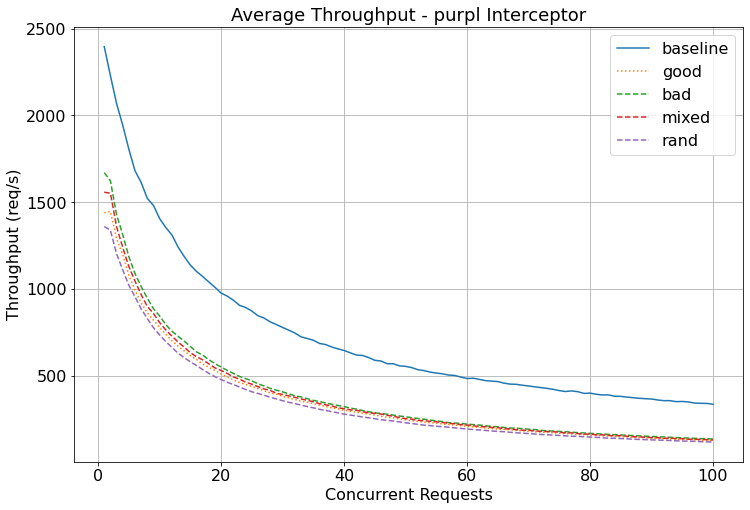

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(avg_purpl_base['Avg. Throughput req/s'], label='baseline')
plt.plot(avg_purpl_good['Avg. Throughput req/s'], label='good', linestyle='dotted')
plt.plot(avg_purpl_bad['Avg. Throughput req/s'], label='bad', linestyle='--')
plt.plot(avg_purpl_mixed['Avg. Throughput req/s'], label='mixed', linestyle='--')
plt.plot(avg_purpl_rand['Avg. Throughput req/s'], label='rand', linestyle='--')


plt.title('Average Throughput - purpl Interceptor', fontsize=18)
plt.ylabel('Throughput (req/s)', fontsize=16)
plt.xlabel('Concurrent Requests', fontsize=16)
plt.grid(True)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)
plt.show()

## How long does it take to send 100.000 requests?

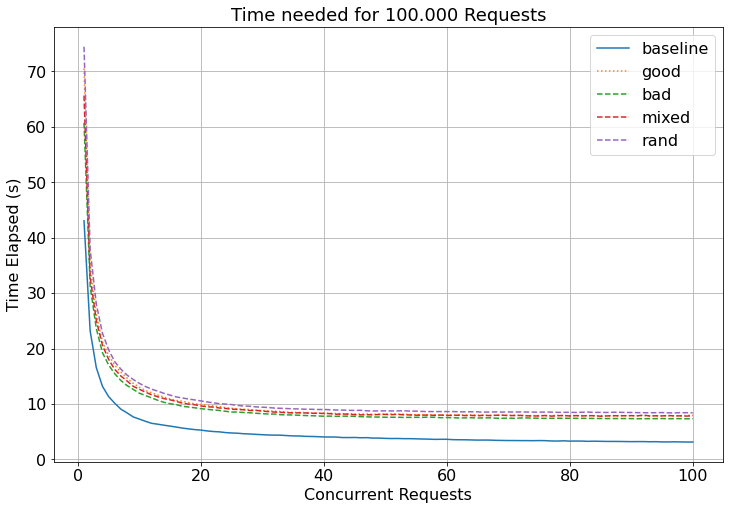

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(avg_purpl_base['Concurrent Requests'], avg_purpl_base ['Time Elapsed'], label='baseline')
plt.plot(avg_purpl_good['Concurrent Requests'], avg_purpl_good ['Time Elapsed'], label='good', linestyle='dotted')
plt.plot(avg_purpl_bad['Concurrent Requests'], avg_purpl_bad ['Time Elapsed'], label='bad', linestyle='--')
plt.plot(avg_purpl_mixed['Concurrent Requests'], avg_purpl_mixed ['Time Elapsed'], label='mixed', linestyle='--')
plt.plot(avg_purpl_rand['Concurrent Requests'], avg_purpl_rand ['Time Elapsed'], label='rand', linestyle='--')

plt.title('Time needed for 100.000 Requests', fontsize=18)
plt.xlabel('Concurrent Requests', fontsize=16)
plt.ylabel('Time Elapsed (s)', fontsize=16)
#plt.yticks(np.arange(0, 1, 0.1))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)
plt.grid(True)
plt.show()

### Experiment runtime

TypeError: only size-1 arrays can be converted to Python scalars

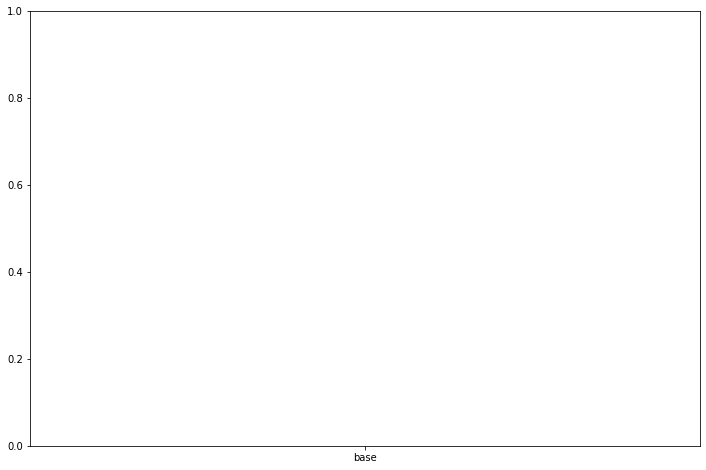

In [28]:
# plotting experiment execution time as bar chart
plt.figure(figsize=(12, 8))
plt.bar('base', avg_purpl_base, label='Baseline (No Interceptor)')
plt.bar('good', avg_purpl_good, label='Good (All Attributes Allowed)')
plt.bar('bad', avg_purpl_bad, label='Bad (All Attributes Supressed)')
plt.bar('mixed', avg_purpl_mixed, label='Mixed (Noised and Reduced Attributes)')
plt.bar('rand', avg_purpl_rand, label='Random (Good, Bad, Mixed)')

plt.title('Benchmarking Run Execution Time')
plt.xlabel('Policy Type')
plt.ylabel('Time Elapsed (s)')
plt.legend()
plt.grid(True)
plt.show()

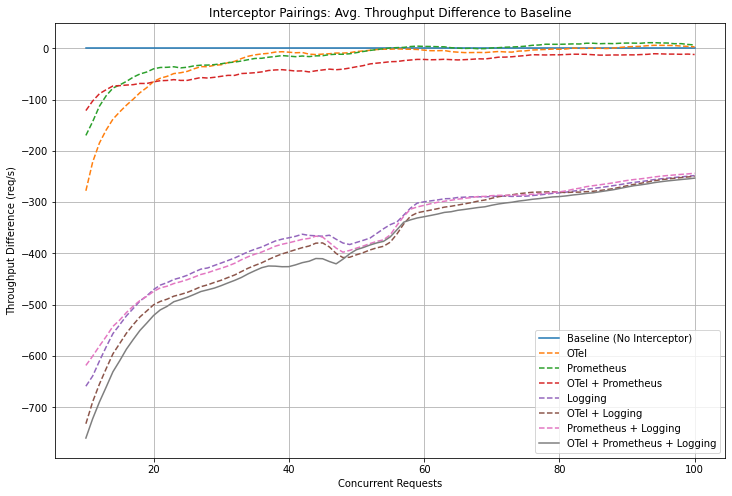

In [ ]:
# plot difference to baseline in absolute numbers
plt.figure(figsize=(12, 8))
plt.plot(avg_data_000['Concurrent Requests'], np.multiply(avg_data_000['Avg. Throughput req/s'].rolling(window=window_size).mean() - avg_data_000['Avg. Throughput req/s'].rolling(window=window_size).mean(), 1), label='Baseline (No Interceptor)') #marker='o',
plt.plot(avg_data_001['Concurrent Requests'], np.multiply(avg_data_001['Avg. Throughput req/s'].rolling(window=window_size).mean() - avg_data_000['Avg. Throughput req/s'].rolling(window=window_size).mean(), 1), linestyle='--', label='OTel') #marker='x',
plt.plot(avg_data_010['Concurrent Requests'], np.multiply(avg_data_010['Avg. Throughput req/s'].rolling(window=window_size).mean() - avg_data_000['Avg. Throughput req/s'].rolling(window=window_size).mean(), 1), linestyle='--', label='Prometheus') #marker='^',
plt.plot(avg_data_011['Concurrent Requests'], np.multiply(avg_data_011['Avg. Throughput req/s'].rolling(window=window_size).mean() - avg_data_000['Avg. Throughput req/s'].rolling(window=window_size).mean(), 1), linestyle='--', label='OTel + Prometheus') #marker='o',
plt.plot(avg_data_100['Concurrent Requests'], np.multiply(avg_data_100['Avg. Throughput req/s'].rolling(window=window_size).mean() - avg_data_000['Avg. Throughput req/s'].rolling(window=window_size).mean(), 1), linestyle='--', label='Logging') #marker='s',
plt.plot(avg_data_101['Concurrent Requests'], np.multiply(avg_data_101['Avg. Throughput req/s'].rolling(window=window_size).mean() - avg_data_000['Avg. Throughput req/s'].rolling(window=window_size).mean(), 1), linestyle='--', label='OTel + Logging') #marker='s',
plt.plot(avg_data_110['Concurrent Requests'], np.multiply(avg_data_110['Avg. Throughput req/s'].rolling(window=window_size).mean() - avg_data_000['Avg. Throughput req/s'].rolling(window=window_size).mean(), 1), linestyle='--', label='Prometheus + Logging') #marker='s',
plt.plot(avg_data_111['Concurrent Requests'], np.multiply(avg_data_111['Avg. Throughput req/s'].rolling(window=window_size).mean() - avg_data_000['Avg. Throughput req/s'].rolling(window=window_size).mean(), 1), label='OTel + Prometheus + Logging') #marker='s',

plt.title('Interceptor Pairings: Avg. Throughput Difference to Baseline')
plt.xlabel('Concurrent Requests')
plt.ylabel('Throughput Difference (req/s)')
plt.legend()
plt.grid(True)
plt.show()


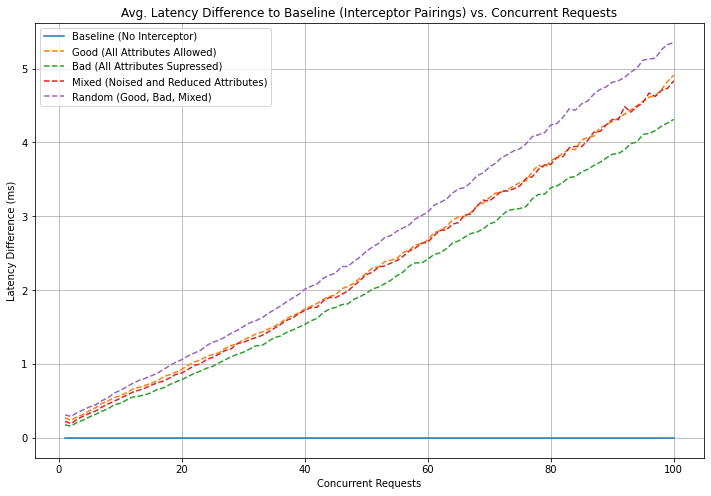

In [30]:
# Latency difference to baseline in absolute numbers
plt.figure(figsize=(12, 8))
# plt.plot(avg_data_000['Concurrent Requests'], avg_data_000['Average Latency'] - avg_data_000['Average Latency'],  label='Baseline (No Interceptor)') #marker='o',
# plt.plot(avg_data_001['Concurrent Requests'], avg_data_001['Average Latency'] - avg_data_000['Average Latency'], linestyle='--', label='OTel') #marker='x',
# plt.plot(avg_data_010['Concurrent Requests'], avg_data_010['Average Latency'] - avg_data_000['Average Latency'], linestyle='--', label='Prometheus') #marker='^',
# plt.plot(avg_data_011['Concurrent Requests'], avg_data_011['Average Latency'] - avg_data_000['Average Latency'], label='OTel + Prometheus') #marker='o',

plt.plot(avg_purpl_base['Concurrent Requests'], avg_purpl_base['Average Latency'] - avg_purpl_base['Average Latency'], label='Baseline (No Interceptor)') #marker='o',
plt.plot(avg_purpl_good['Concurrent Requests'], avg_purpl_good['Average Latency'] - avg_purpl_base['Average Latency'], linestyle='--', label='Good (All Attributes Allowed)') #marker='x',
plt.plot(avg_purpl_bad['Concurrent Requests'], avg_purpl_bad['Average Latency'] - avg_purpl_base['Average Latency'], linestyle='--', label='Bad (All Attributes Supressed)') #marker='^',
plt.plot(avg_purpl_mixed['Concurrent Requests'], avg_purpl_mixed['Average Latency'] - avg_purpl_base['Average Latency'], linestyle='--', label='Mixed (Noised and Reduced Attributes)') #marker='s',
plt.plot(avg_purpl_rand['Concurrent Requests'], avg_purpl_rand['Average Latency'] - avg_purpl_base['Average Latency'], linestyle='--', label='Random (Good, Bad, Mixed)') #marker='s',

plt.title('Avg. Latency Difference to Baseline (Interceptor Pairings) vs. Concurrent Requests')
plt.xlabel('Concurrent Requests')
plt.ylabel('Latency Difference (ms)')
plt.legend()
plt.grid(True)
plt.show()